In [1]:
from keras.datasets.cifar10 import load_data

In [2]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint

In [3]:
# load images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)


Train (50000, 32, 32, 3) (50000, 1)
Test (10000, 32, 32, 3) (10000, 1)


In [4]:
from matplotlib import pyplot

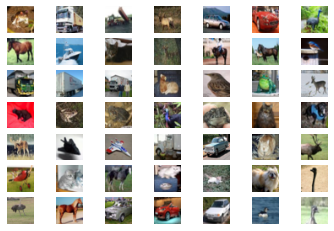

In [5]:
# plot raw pixel data
for i in range(49):
    # define subplot
    pyplot.subplot(7,7,1+i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i])
pyplot.show()

In [6]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

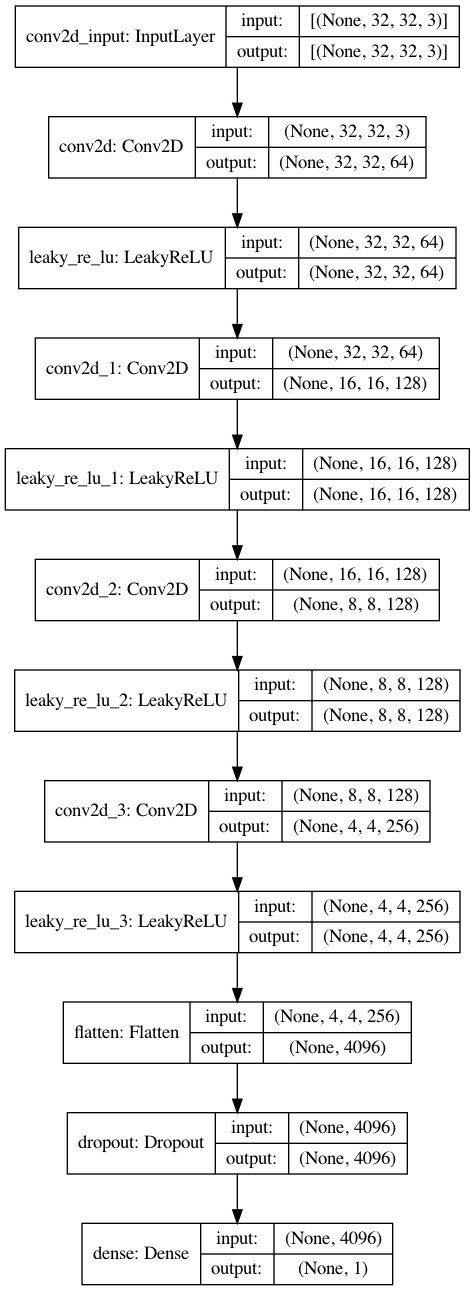

In [7]:
# define the standalone discriminator model

# run necessary imports

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    #downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    #compile model
    opt = Adam(learning_rate = 0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    
    
# define model
model = define_discriminator()
# summarize the model
model.summary()
#plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [8]:
# function to load and prepare dataset

def load_real_samples():
    

    # load cifar10 dataset - just use the input
    (trainX, _), (_,_) = load_data()

    # normalise pixel values

    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    
    return X

In [9]:
# function to generate random samples of images on which to train the model
def generate_real_samples(dataset, n_samples):
    #choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    #retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [10]:
# function to generate random fake samples with class labels
def generate_fake_samples(n_samples):
    #general uniform random numbers in [0,1]
    X = rand(32 * 32 * 3 * n_samples)
    # update to have the range [-1, 1]
    X = -1 + X * 2
    # reshape into a batch of colour images
    X = X.reshape((n_samples, 32, 32, 3))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [11]:
# function to train the discriminator model

def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [12]:
# define the discriminator model
model = define_discriminator()

# load image data
dataset = load_real_samples()

# fit the model
train_discriminator(model, dataset)

>1 real=88% fake=0%
>2 real=100% fake=0%
>3 real=100% fake=0%
>4 real=100% fake=5%
>5 real=100% fake=19%
>6 real=100% fake=58%
>7 real=95% fake=83%
>8 real=100% fake=98%
>9 real=98% fake=100%
>10 real=100% fake=100%
>11 real=91% fake=100%
>12 real=98% fake=100%
>13 real=98% fake=100%
>14 real=98% fake=100%
>15 real=97% fake=100%
>16 real=98% fake=100%
>17 real=100% fake=100%
>18 real=100% fake=100%
>19 real=100% fake=100%
>20 real=100% fake=100%


<h2>Define and use the generator model</h2>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 128)      

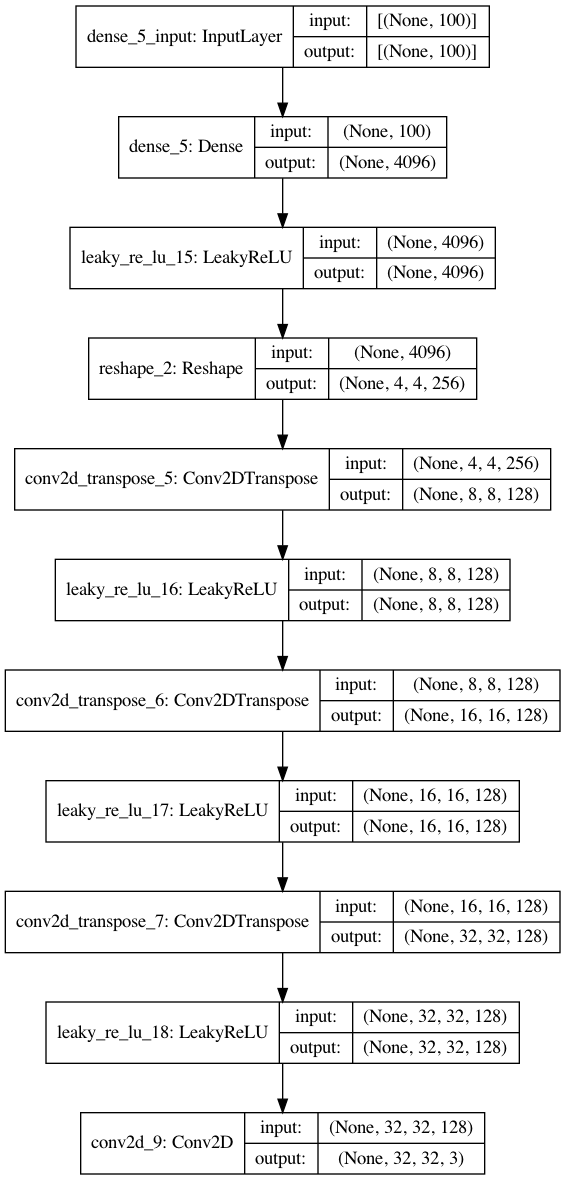

In [21]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model


# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 *4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4,4,256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    #upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model


# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model 
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
# generate points in latent space as input for the generator
from numpy import zeros
from numpy.random import randn

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [31]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

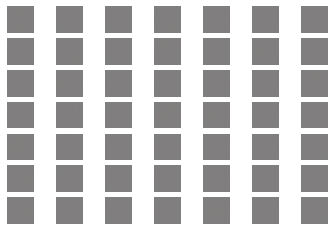

In [33]:
# example of generating new CIFAR-10 images with the untrained generator

# size of the latent space
latent_dim = 100
# define generator model
model = define_generator(latent_dim)
# generatr samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# scale pixel values from [-1,1] to [0,1]
X = (X+1)/2
# plot the generated samples
for i in range(n_samples):
    # define subplot
    pyplot.subplot(7,7,1+i)
    # turn off axis labels
    pyplot.axis('off')
    # plot single image
    pyplot.imshow(X[i])
# show the figure
pyplot.show()

<h2>Train the generator model</h2>